Возьмем модель, которая изначально не может решить нашу задачу, но, проделав ряд трансформаций, результат будет достигнут. Будем распозновать номер автомобиля, использовав модель, определяющую рукописные буквы и цифры (основываясь на подборке изображений EMNIST).

Начнем с самой модели.

Загружаем необходимые библиотеки:

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.constraints import maxnorm
import tensorflow as tf
import zipfile
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Строим модель

In [ ]:
def emnist_model():
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='valid', input_shape=(28, 28, 1), activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(emnist_labels), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

Исходный датасет EMNIST имеет 62 разных символа (A..Z, 0..9 и пр):


In [ ]:
emnist_labels = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]

In [ ]:
!wget https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip

--2023-06-11 12:02:19--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 132.163.4.175, 2610:20:6b01:4::175
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M  16.5MB/s    in 34s     

2023-06-11 12:02:54 (15.7 MB/s) - ‘gzip.zip’ saved [561753746/561753746]



In [ ]:
zip_file = "/content/gzip.zip"
if not os.path.exists('sample_data/emnist/'):
  os.makedirs('sample_data/emnist/')
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    z.extract(file, '/content/sample_data/emnist/')

In [ ]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=fe6dcb7c9f8c93a89ab9022b495dd4102c98227f3dc6a682d3d38d8c4cf3112d
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [ ]:
import idx2numpy
import gzip
import shutil

In [ ]:
if not os.path.exists('/content/sample_data/emnist/gzip/test/'):
  os.makedirs('/content/sample_data/emnist/gzip/test/')
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-test-labels-idx1-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-test-labels-idx1-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-test-images-idx3-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-test-images-idx3-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-train-labels-idx1-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-train-labels-idx1-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)
zip_file = "/content/sample_data/emnist/gzip/emnist-byclass-train-images-idx3-ubyte.gz"
with gzip.open(zip_file, 'rb') as z:
    with open('/content/sample_data/emnist/gzip/test/emnist-byclass-train-images-idx3-ubyte', 'wb') as f:
        shutil.copyfileobj(z, f)

In [ ]:
emnist_path = '/content/sample_data/emnist/gzip/test/'
X_train = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-train-labels-idx1-ubyte')

X_test = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-test-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file(emnist_path + 'emnist-byclass-test-labels-idx1-ubyte')

X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(emnist_labels))

k = 10
X_train = X_train[:X_train.shape[0] // k]
y_train = y_train[:y_train.shape[0] // k]
X_test = X_test[:X_test.shape[0] // k]
y_test = y_test[:y_test.shape[0] // k]

# Normalize
X_train = X_train.astype(np.float32)
X_train /= 255.0
X_test = X_test.astype(np.float32)
X_test /= 255.0

x_train_cat = keras.utils.to_categorical(y_train, len(emnist_labels))
y_test_cat = keras.utils.to_categorical(y_test, len(emnist_labels))

(697932, 28, 28, 1) (697932,) (116323, 28, 28, 1) (116323,) 62


In [ ]:
model = keras.models.load_model('emnist_symbols.h5')

В целях экономии времени можно пропустить следующий шаг и загрузить обученную модель из файла "emnist_symbols.h5"

In [ ]:
# Set a learning rate reduction
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

model = emnist_model()
model.fit(X_train, x_train_cat, validation_data=(X_test, y_test_cat), callbacks=[learning_rate_reduction], batch_size=64, epochs=50)

model.save('emnist_symbols.h5')

Epoch 1/50
1091/1091 [==============================] - 20s 7ms/step - loss: 4.0127 - accuracy: 0.0716 - val_loss: 3.8568 - val_accuracy: 0.1932 - lr: 0.0010
Epoch 2/50
1091/1091 [==============================] - 8s 7ms/step - loss: 3.7216 - accuracy: 0.1484 - val_loss: 3.5204 - val_accuracy: 0.2820 - lr: 0.0010
Epoch 3/50
1091/1091 [==============================] - 8s 7ms/step - loss: 3.4390 - accuracy: 0.2227 - val_loss: 3.2141 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 4/50
1091/1091 [==============================] - 8s 7ms/step - loss: 3.1860 - accuracy: 0.2884 - val_loss: 2.9235 - val_accuracy: 0.4112 - lr: 0.0010
Epoch 5/50
1091/1091 [==============================] - 8s 7ms/step - loss: 2.9409 - accuracy: 0.3355 - val_loss: 2.6535 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 6/50
1091/1091 [==============================] - 8s 7ms/step - loss: 2.7197 - accuracy: 0.3740 - val_loss: 2.4265 - val_accuracy: 0.4534 - lr: 0.0010
Epoch 7/50
1091/1091 [==============================] - 8

Загрузим изображение автомобиля с номерным знаком и выделим этот знак.

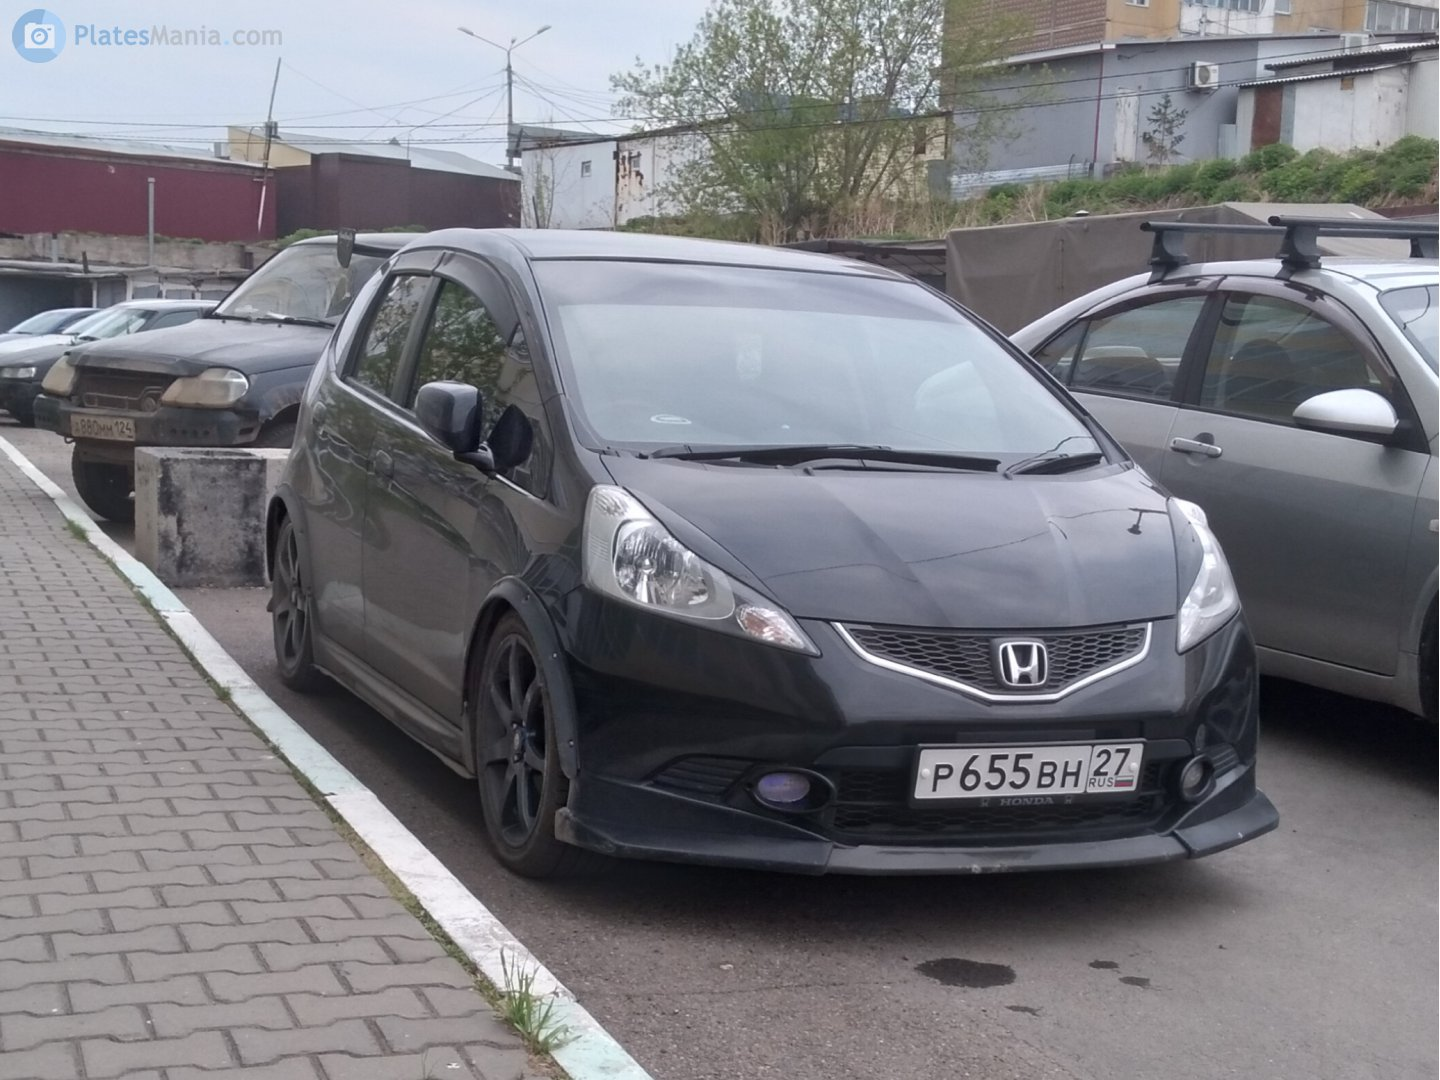

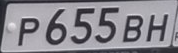

In [ ]:
img = cv2.imread('/content/vehicleNum.jpg')
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # переводим в градации серого
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2) # устанавливаем порог для дальнейшего определения контура номерного знака
cv2_imshow(thresh)
contours,h = cv2.findContours(thresh,1,2) # находим контуры
img_contor = cv2.drawContours(img, contours, -1, (0,255,0), 3)
cv2_imshow(img_contor)
largest_rectangle = [0,0]
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
    if len(approx)==4: # В нашем примере мы делаем допущение, что номерной знак - четырехугольник.
        area = cv2.contourArea(cnt)
        if area > largest_rectangle[0]:
            largest_rectangle = [cv2.contourArea(cnt), cnt, approx]

x,y,w,h = cv2.boundingRect(largest_rectangle[1])
vehicle_num=img[y:y+h,x:x+w] # оставляем на исходном изображении только номер автомобиля
cv2_imshow(vehicle_num)

Разобъем номер на отдельные буквы/цифры, чтобы на вход модели подавать по одному символу. Заодно и определим размер изображения каждого символа, как 28х28 (это необходимо для дальнейшего использования в нашей модели).

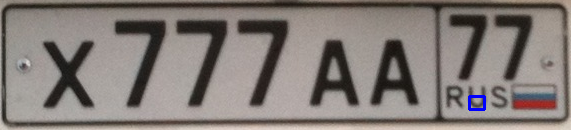

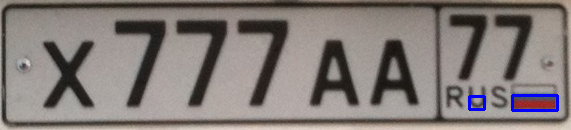

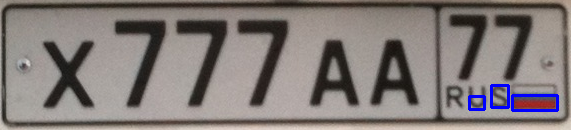

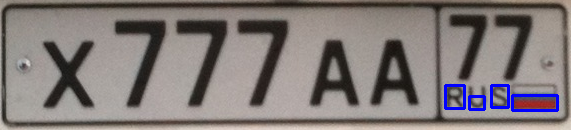

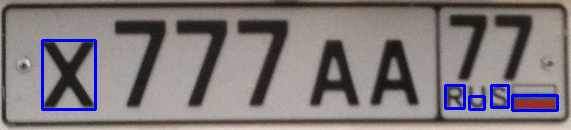

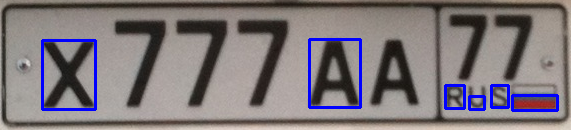

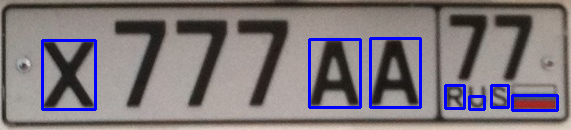

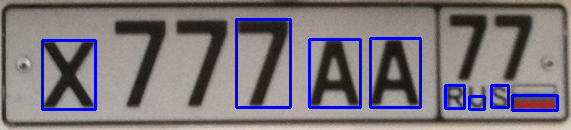

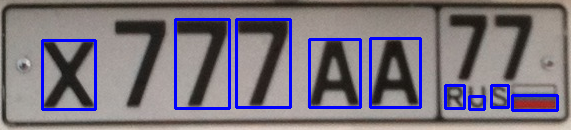

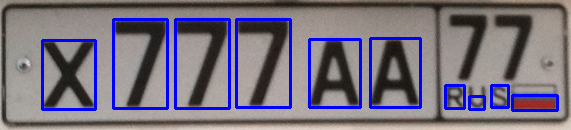

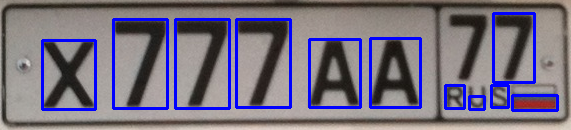

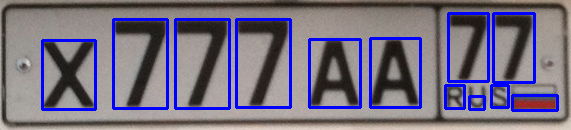

Выводим каждый символ отдельно, отсортировав по координате Х


In [ ]:
gray = cv2.cvtColor(vehicle_num, cv2.COLOR_BGR2GRAY) # уже работаем с выделенным участком изображения
ret, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY)
img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1) # размываем границы объекта
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # находим контуры, используя иерархическую структуру
output = vehicle_num.copy()
letters = []
for idx, contour in enumerate(contours):
  (x, y, w, h) = cv2.boundingRect(contour)
  if w > 10 and h > 10:
    if hierarchy[0][idx][3] == 0:
      cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
      letter_crop = gray[y:y + h, x:x + w]
      cv2_imshow(output)
      size_max = max(w, h) # выделяем область в виде квадрата
      letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
      if w > h:
        y_pos = size_max//2 - h//2
        letter_square[y_pos:y_pos + h, 0:w] = letter_crop
      elif w < h:
        x_pos = size_max//2 - w//2
        letter_square[0:h, x_pos:x_pos + w] = letter_crop
      else:
        letter_square = letter_crop
      out_size = 28  # устанавливаем размеры результирующего изображения для каждой буквы
      letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
letters.sort(key=lambda x: x[0], reverse=False) # сортируем относительно координаты Х
print("Выводим каждый символ отдельно, отсортировав по координате Х")
for i in range(0,len(letters)):
  cv2_imshow(letters[i][2])


Предобученную модель можно загрузить из файла:

In [ ]:
!gdown --id 1tLZ_bMsyjRTKjessSL0ljOAscPp6Tw-T

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tLZ_bMsyjRTKjessSL0ljOAscPp6Tw-T
To: /content/emnist_symbols.h5
100% 57.3M/57.3M [00:00<00:00, 137MB/s]


In [ ]:
model = keras.models.load_model('/content/emnist_symbols.h5')

Определим функцию предсказаний. Тут важно иметь в виду, что исходные данные для обучения и тренировки модели имеют размер 28х28 и перевернуты (для этого мы будем использовать np.fliplr и np.rot90).

In [ ]:
def emnist_predict_img(model, img):
    img_arr = np.expand_dims(img, axis=0)
    img_arr = 1 - img_arr/255.0
    img_arr[0] = np.rot90(img_arr[0], 3)
    img_arr[0] = np.fliplr(img_arr[0])
    img_arr = img_arr.reshape((1, 28, 28, 1))
    result = np.argmax(model.predict([img_arr]), axis=1)
    return chr(emnist_labels[result[0]])

Поскольку у нас некая последовательность изображений, напишем соответсвующую функцию:

In [ ]:
def img_to_str(model, letters):
    result = ""
    for i in range(len(letters)):
        dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
        cv2_imshow(letters[i][2])
        result += emnist_predict_img(model, letters[i][2])
        if (dn > letters[i][1]/4):
            result += ' '
    return result

In [ ]:
result = img_to_str(model, letters)
print(result)

1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
X 777 22 R7W B7M


Видно, что не все символы были распознаны корректно.


Данные пример ни в коем случае не показывает, как решать эту конкретную задачу, а демонстрирует возможности Feature Engineering. Мы рассмотрели не практический, а теоретический подход.